## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0, 1, 2, 3, 4, 5, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [ ]:
from astrid_GAN import AstridGAN

gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = AstridGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")

# Online training during the test period
# Assume test_returns_df contains daily returns for the test period
for test_day in test_returns_df.index:
    for asset_name in test_returns_df.columns:
        new_return = test_returns_df.loc[test_day, asset_name]
        gan = gan_dict[asset_name]
        
        # Process the new return (online_training handles fine-tuning or full retraining as needed)
        gan.online_training(new_return)
        print(f"{asset_name}: Processed online update for new return on {test_day}.")
        
        # Generate scenarios with the updated GAN
        scenarios = gan.generate_scenarios(num_scenarios=10000)
        
        # Store the generated scenarios for this test day
        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")

# At this point, scenarios_results contains the generated scenario distribution for each asset keyed by date.


Training GANs:   0%|          | 0/7 [00:00<?, ?asset/s]

Training GAN for REEL...
[Epoch 0/10] [Batch 0/15] [D loss: 0.06906545162200928] [G loss: -0.17115448415279388]
[Epoch 0/10] [Batch 10/15] [D loss: 0.06617704033851624] [G loss: -0.2380201518535614]
[Epoch 1/10] [Batch 0/15] [D loss: -0.0995236486196518] [G loss: -0.11274360865354538]
[Epoch 1/10] [Batch 10/15] [D loss: 0.12594938278198242] [G loss: -0.03251723200082779]
[Epoch 2/10] [Batch 0/15] [D loss: 0.14414995908737183] [G loss: -0.14414729177951813]
[Epoch 2/10] [Batch 10/15] [D loss: -0.007060691714286804] [G loss: -0.07093024253845215]
[Epoch 3/10] [Batch 0/15] [D loss: -0.00699416920542717] [G loss: 0.06294428557157516]
[Epoch 3/10] [Batch 10/15] [D loss: 0.004237502813339233] [G loss: 0.1016550064086914]
[Epoch 4/10] [Batch 0/15] [D loss: 0.18218877911567688] [G loss: -0.1454334259033203]
[Epoch 4/10] [Batch 10/15] [D loss: 0.0004371330142021179] [G loss: -0.08373825997114182]
[Epoch 5/10] [Batch 0/15] [D loss: 0.14637219905853271] [G loss: -0.11800044775009155]
[Epoch 5/10]

Training GANs:  14%|█▍        | 1/7 [00:05<00:34,  5.73s/asset]

[Epoch 9/10] [Batch 10/15] [D loss: -0.005519852042198181] [G loss: -0.02211148291826248]
Finished training GAN for REEL.

Finished generating scenarios for REEL.

REEL: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for PE...
[Epoch 0/10] [Batch 0/15] [D loss: 0.009547650814056396] [G loss: 0.45447269082069397]
[Epoch 0/10] [Batch 10/15] [D loss: -0.27637889981269836] [G loss: 0.294770210981369]
[Epoch 1/10] [Batch 0/15] [D loss: -0.22526651620864868] [G loss: 0.3746679723262787]
[Epoch 1/10] [Batch 10/15] [D loss: 0.09540662169456482] [G loss: 0.20963220298290253]
[Epoch 2/10] [Batch 0/15] [D loss: -0.13419601321220398] [G loss: 0.4281187355518341]
[Epoch 2/10] [Batch 10/15] [D loss: -0.09231433272361755] [G loss: 0.4572819769382477]
[Epoch 3/10] [Batch 0/15] [D loss: -0.11589747667312622] [G loss: 0.4495292007923126]
[Epoch 3/10] [Batch 10/15] [D loss: 0.14032119512557983] [G loss: 0.4311455488204956]
[Epoch 4/10] [Batch 0/15] [D loss: 0.03420501947402954] 

Training GANs:  29%|██▊       | 2/7 [00:10<00:24,  4.90s/asset]

Training GAN for MSCIWORLD...
[Epoch 0/10] [Batch 0/15] [D loss: -0.27784639596939087] [G loss: 0.008054060861468315]
[Epoch 0/10] [Batch 10/15] [D loss: 0.07642476260662079] [G loss: 0.030358746647834778]
[Epoch 1/10] [Batch 0/15] [D loss: 0.06030680984258652] [G loss: 0.0802614763379097]
[Epoch 1/10] [Batch 10/15] [D loss: -0.11211258918046951] [G loss: 0.10822514444589615]
[Epoch 2/10] [Batch 0/15] [D loss: -0.15815633535385132] [G loss: 0.07514980435371399]
[Epoch 2/10] [Batch 10/15] [D loss: -0.08528746664524078] [G loss: 0.11499576270580292]
[Epoch 3/10] [Batch 0/15] [D loss: -0.12414013594388962] [G loss: 0.09003604203462601]
[Epoch 3/10] [Batch 10/15] [D loss: -0.08787647634744644] [G loss: 0.18443459272384644]
[Epoch 4/10] [Batch 0/15] [D loss: -0.13101743161678314] [G loss: -0.0211980938911438]
[Epoch 4/10] [Batch 10/15] [D loss: -0.05733901262283325] [G loss: 0.143616184592247]
[Epoch 5/10] [Batch 0/15] [D loss: -0.07862944900989532] [G loss: 0.0988147184252739]
[Epoch 5/10]

Training GANs:  43%|████▎     | 3/7 [00:14<00:18,  4.68s/asset]

[Epoch 9/10] [Batch 10/15] [D loss: -0.19761739671230316] [G loss: 0.24529314041137695]
Finished training GAN for MSCIWORLD.

Finished generating scenarios for MSCIWORLD.

MSCIWORLD: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for IG...
[Epoch 0/10] [Batch 0/15] [D loss: -0.07637303322553635] [G loss: 0.2602146565914154]
[Epoch 0/10] [Batch 10/15] [D loss: -0.025943070650100708] [G loss: 0.15283113718032837]
[Epoch 1/10] [Batch 0/15] [D loss: 0.09131740033626556] [G loss: 0.28122562170028687]
[Epoch 1/10] [Batch 10/15] [D loss: 0.035345304757356644] [G loss: 0.046926096081733704]
[Epoch 2/10] [Batch 0/15] [D loss: 0.1142435222864151] [G loss: 0.061217278242111206]
[Epoch 2/10] [Batch 10/15] [D loss: 0.061776429414749146] [G loss: 0.08152595162391663]
[Epoch 3/10] [Batch 0/15] [D loss: 0.04338669031858444] [G loss: 0.20622293651103973]
[Epoch 3/10] [Batch 10/15] [D loss: 0.0672474354505539] [G loss: 0.3071039021015167]
[Epoch 4/10] [Batch 0/15] [D loss: 0.06

Training GANs:  57%|█████▋    | 4/7 [00:19<00:13,  4.62s/asset]

[Epoch 9/10] [Batch 10/15] [D loss: -0.10830815136432648] [G loss: 0.1578611582517624]
Finished training GAN for IG.

Finished generating scenarios for IG.

IG: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for GOV...
[Epoch 0/10] [Batch 0/15] [D loss: 0.0002899095416069031] [G loss: 0.13465698063373566]
[Epoch 0/10] [Batch 10/15] [D loss: -0.1197786033153534] [G loss: 0.15505088865756989]
[Epoch 1/10] [Batch 0/15] [D loss: -0.06258593499660492] [G loss: 0.10225021094083786]
[Epoch 1/10] [Batch 10/15] [D loss: -0.07002080976963043] [G loss: 0.019687075167894363]
[Epoch 2/10] [Batch 0/15] [D loss: 0.031552866101264954] [G loss: 0.12255707383155823]
[Epoch 2/10] [Batch 10/15] [D loss: 0.26164746284484863] [G loss: -0.08258401602506638]
[Epoch 3/10] [Batch 0/15] [D loss: -0.08181032538414001] [G loss: 0.20541346073150635]
[Epoch 3/10] [Batch 10/15] [D loss: -0.1155717670917511] [G loss: 0.16352319717407227]
[Epoch 4/10] [Batch 0/15] [D loss: -0.11573277413845062

Training GANs:  71%|███████▏  | 5/7 [00:23<00:09,  4.56s/asset]

[Epoch 9/10] [Batch 10/15] [D loss: 0.05243279039859772] [G loss: 0.17403434216976166]
Finished training GAN for GOV.

Finished generating scenarios for GOV.

GOV: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for HY...
[Epoch 0/10] [Batch 0/15] [D loss: -0.05409173667430878] [G loss: 0.08563113957643509]
[Epoch 0/10] [Batch 10/15] [D loss: 0.04412068426609039] [G loss: 0.0208082627505064]
[Epoch 1/10] [Batch 0/15] [D loss: 0.08594010770320892] [G loss: 0.08623014390468597]
[Epoch 1/10] [Batch 10/15] [D loss: 0.09770375490188599] [G loss: 0.1399056613445282]
[Epoch 2/10] [Batch 0/15] [D loss: -0.1506108045578003] [G loss: 0.20103605091571808]
[Epoch 2/10] [Batch 10/15] [D loss: 0.04438968002796173] [G loss: 0.10679227113723755]
[Epoch 3/10] [Batch 0/15] [D loss: -0.1614895462989807] [G loss: 0.28668344020843506]
[Epoch 3/10] [Batch 10/15] [D loss: -0.151910662651062] [G loss: 0.29408887028694153]
[Epoch 4/10] [Batch 0/15] [D loss: -0.23146437108516693] [G los

Training GANs:  86%|████████▌ | 6/7 [00:28<00:04,  4.61s/asset]

[Epoch 9/10] [Batch 10/15] [D loss: -0.058388710021972656] [G loss: 0.5752731561660767]
Finished training GAN for HY.

Finished generating scenarios for HY.

HY: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for EONIA...
[Epoch 0/10] [Batch 0/15] [D loss: -0.11928990483283997] [G loss: 0.09526532888412476]
[Epoch 0/10] [Batch 10/15] [D loss: -0.0020823627710342407] [G loss: 0.28634539246559143]
[Epoch 1/10] [Batch 0/15] [D loss: -0.08734104037284851] [G loss: 0.44704627990722656]
[Epoch 1/10] [Batch 10/15] [D loss: -0.1450147032737732] [G loss: 0.25197353959083557]
[Epoch 2/10] [Batch 0/15] [D loss: -0.07054615020751953] [G loss: 0.3700037896633148]
[Epoch 2/10] [Batch 10/15] [D loss: -0.20410248637199402] [G loss: 0.288232684135437]
[Epoch 3/10] [Batch 0/15] [D loss: -0.15137454867362976] [G loss: 0.4740028381347656]
[Epoch 3/10] [Batch 10/15] [D loss: -0.019071072340011597] [G loss: 0.5744419097900391]
[Epoch 4/10] [Batch 0/15] [D loss: -0.16259849071502686

Training GANs: 100%|██████████| 7/7 [00:32<00:00,  4.70s/asset]

[Epoch 9/10] [Batch 10/15] [D loss: -0.13089138269424438] [G loss: 1.1782562732696533]
Finished training GAN for EONIA.

Finished generating scenarios for EONIA.

EONIA: Stored initial generated scenarios for 2019-12-31 00:00:00.


REEL: Weighted online fine-tuning update completed for new return 0.0048936249211004.
REEL: Processed online update for new return on 2020-01-02 00:00:00.
REEL: Stored generated scenarios for 2020-01-02 00:00:00.
PE: Weighted online fine-tuning update completed for new return 0.0066035017774115.
PE: Processed online update for new return on 2020-01-02 00:00:00.
PE: Stored generated scenarios for 2020-01-02 00:00:00.
MSCIWORLD: Weighted online fine-tuning update completed for new return 0.0096251695352116.
MSCIWORLD: Processed online update for new return on 2020-01-02 00:00:00.
MSCIWORLD: Stored generated scenarios for 2020-01-02 00:00:00.
IG: Weighted online fine-tuning update completed for new return 0.0021571143816725.
IG: Processed online update for new return on 2020-01-02 00:00:00.
IG: Stored generated scenarios for 2020-01-02 00:00:00.
GOV: Weighted online fine-tuning update completed for new return 0.0025188655486165.
GOV: Processed online update for new return on 2020-01-02 00

In [ ]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

In [ ]:
asset_names = list(returns_df.columns)

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

for date in all_dates:
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.
    portfolio = SimpleGANPortfolio(gan_samples, weights)
    _, scr = portfolio.calculate_distribution_and_scr()
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


Date 2019-12-31 00:00:00: SCR = -165142.15702205373
Date 2020-01-02 00:00:00: SCR = -188942.3430844389
Date 2020-01-03 00:00:00: SCR = -168963.4501635632
Date 2020-01-06 00:00:00: SCR = -125709.42330726636
Date 2020-01-07 00:00:00: SCR = -289502.2247474234
Date 2020-01-08 00:00:00: SCR = -171919.6533758898
Date 2020-01-09 00:00:00: SCR = -205784.74747982563
Date 2020-01-10 00:00:00: SCR = -210687.21920467642
Date 2020-01-13 00:00:00: SCR = -215065.43064350932
Date 2020-01-14 00:00:00: SCR = -192050.99539692464
Date 2020-01-15 00:00:00: SCR = -183117.49298736852
Date 2020-01-16 00:00:00: SCR = -250558.45211937235
Date 2020-01-17 00:00:00: SCR = -224375.33050024853
Date 2020-01-20 00:00:00: SCR = -162635.1924766431
Date 2020-01-21 00:00:00: SCR = -180635.179034966
Date 2020-01-22 00:00:00: SCR = -285022.84806692123
Date 2020-01-23 00:00:00: SCR = -276659.33305944706
Date 2020-01-24 00:00:00: SCR = -185255.07472318658
Date 2020-01-27 00:00:00: SCR = -331389.6328135244
Date 2020-01-28 00:0

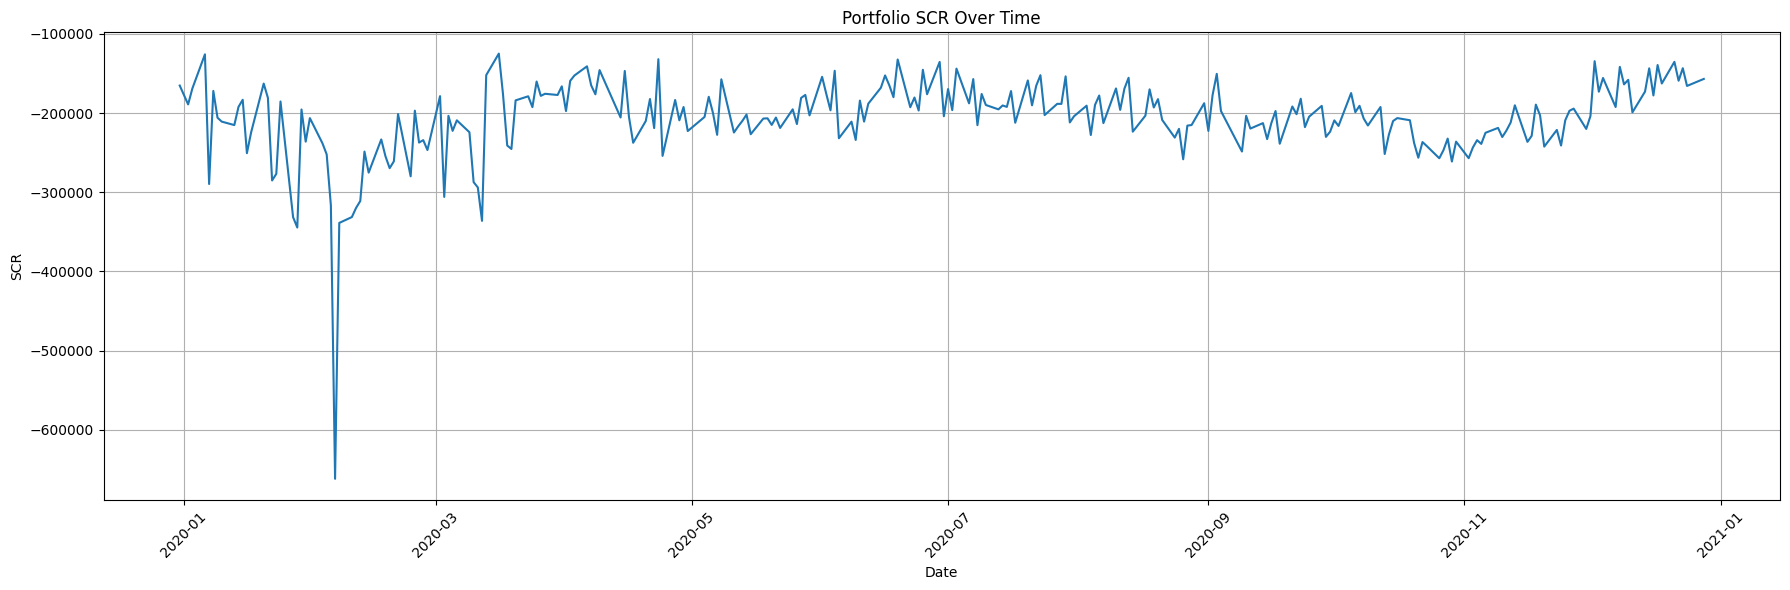

In [ ]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## We need to get rolling Delta BOF

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


In [ ]:
test_start_date = test_returns_df.index.min()
print(test_start_date)

cutoff_date = test_start_date - pd.Timedelta(days=252)

historical_df = entire_df.loc[cutoff_date:]

historical_df.head()

2020-01-02 00:00:00


,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2019-04-25,-0.006224,0.004103,0.003786,-0.000216,-0.001686,-0.001023,-0.000010
2019-04-26,-0.003176,0.004320,0.002331,0.001602,0.002622,0.000301,-0.000010
2019-04-29,-0.000818,0.004778,0.000658,-0.001038,-0.000296,0.000885,-0.000031
2019-04-30,-0.003589,-0.005772,-0.002166,0.001101,0.000217,0.000636,-0.000010
2019-05-02,0.007208,0.000127,-0.005755,-0.001741,0.000427,-0.000861,-0.000010


In [ ]:
# CALCULATE DELTA BOF ARRAY
#entire_df = historical_df

eonia = entire_df.iloc[:, -1]

portfolio_returns = (entire_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

bof_0 = assets_0 - liabilities_0

delta_bof = bof - bof_0 # Delta BOF

daily_delta_bof = bof.diff().fillna(0)

delta_bof = daily_delta_bof


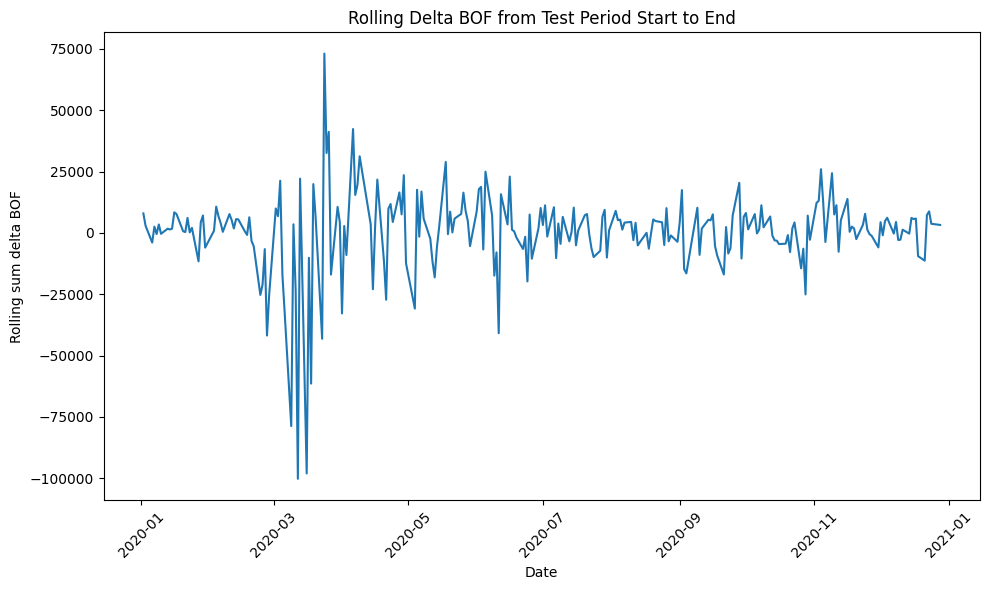

In [ ]:
test_start_date = test_returns_df.index[0]
test_end_date = test_returns_df.index[-1]

# Option A: If you want the rolling measure only for the test period,
# you can extract it from the rolling_delta_bof Series:
test_delta_bof = delta_bof.loc[test_start_date:test_end_date]
plt.figure(figsize=(10, 6))
plt.plot(test_delta_bof.index, test_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Rolling sum delta BOF")
plt.title("Rolling Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

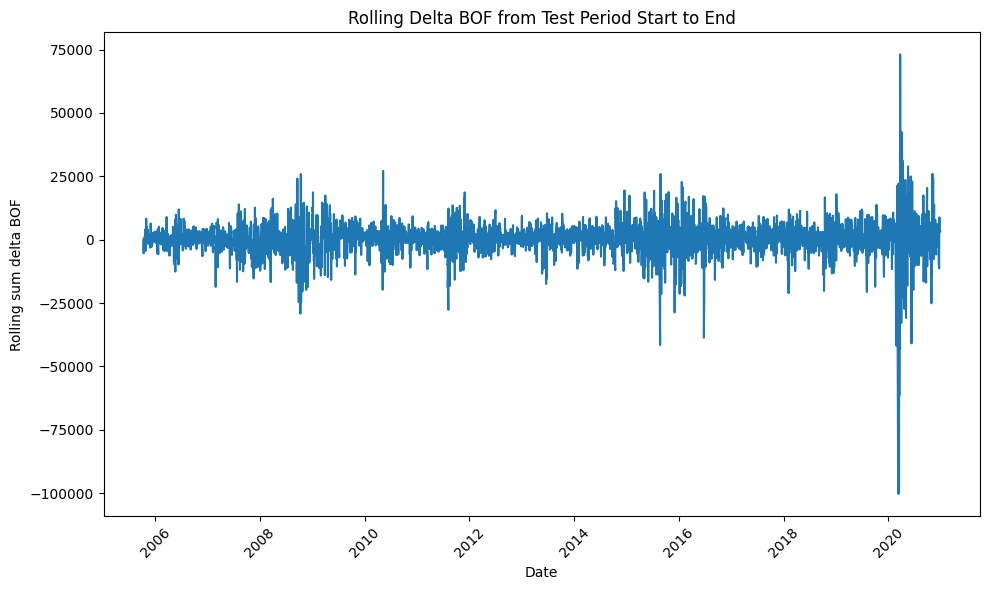

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(delta_bof.index, delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Rolling sum delta BOF")
plt.title("Rolling Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

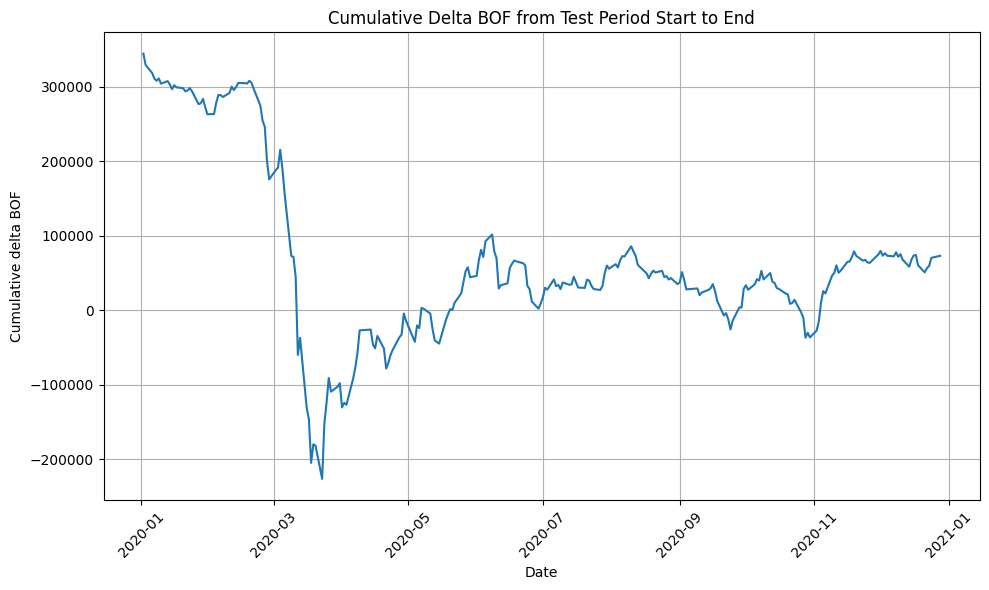

In [ ]:
# Suppose delta_bof is a pandas Series with a datetime index:
# For example:
# delta_bof = pd.Series(data_array, index=date_index)

# 1. Transform the daily delta_bof to a rolling 252-day basis.
#    Here, we compute the rolling sum over 252 days.
rolling_delta_bof = delta_bof.rolling(window=252).sum()

# 2. Determine the test period.
# Assume that returns_df contains historical data and test_returns_df contains the test period.
# Let test_start be the first date in test_returns_df.
test_start_date = test_returns_df.index[0]
test_end_date = test_returns_df.index[-1]

# Option A: If you want the rolling measure only for the test period,
# you can extract it from the rolling_delta_bof Series:
rolling_test = rolling_delta_bof.loc[test_start_date:test_end_date]

# Option B: If you instead want to calculate the cumulative delta_bof (running sum)
# over the test period (starting at test_start), do this:
delta_bof_test = delta_bof.loc[test_start_date:test_end_date]
cumulative_delta_bof_test = delta_bof_test.cumsum()

# 3. Plot the cumulative delta_bof over the test period.
plt.figure(figsize=(10, 6))
plt.plot(rolling_test.index, rolling_test.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Cumulative delta BOF")
plt.title("Cumulative Delta BOF from Test Period Start to End")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

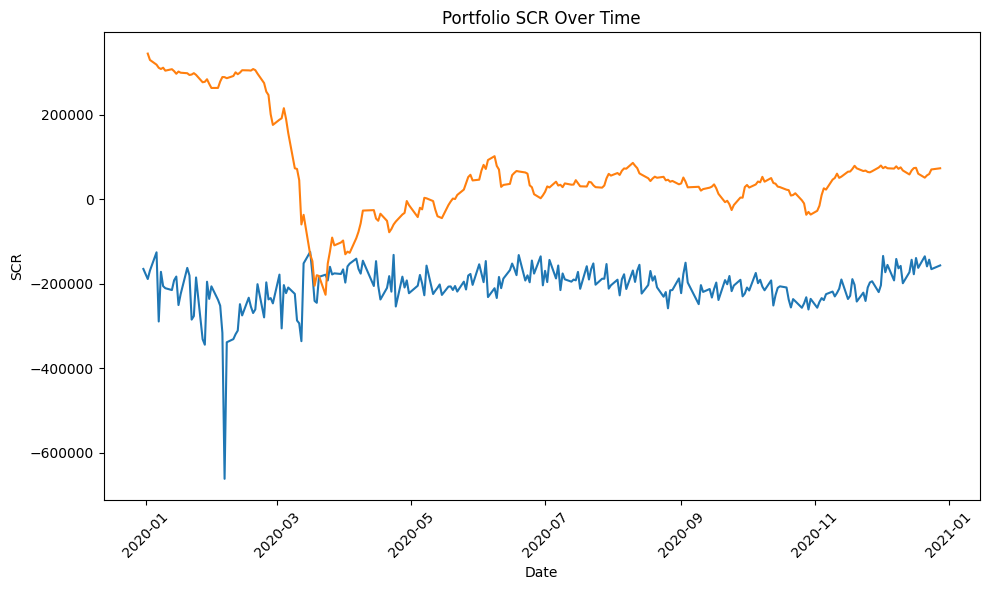

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_test.index, rolling_test.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
Scaled = False


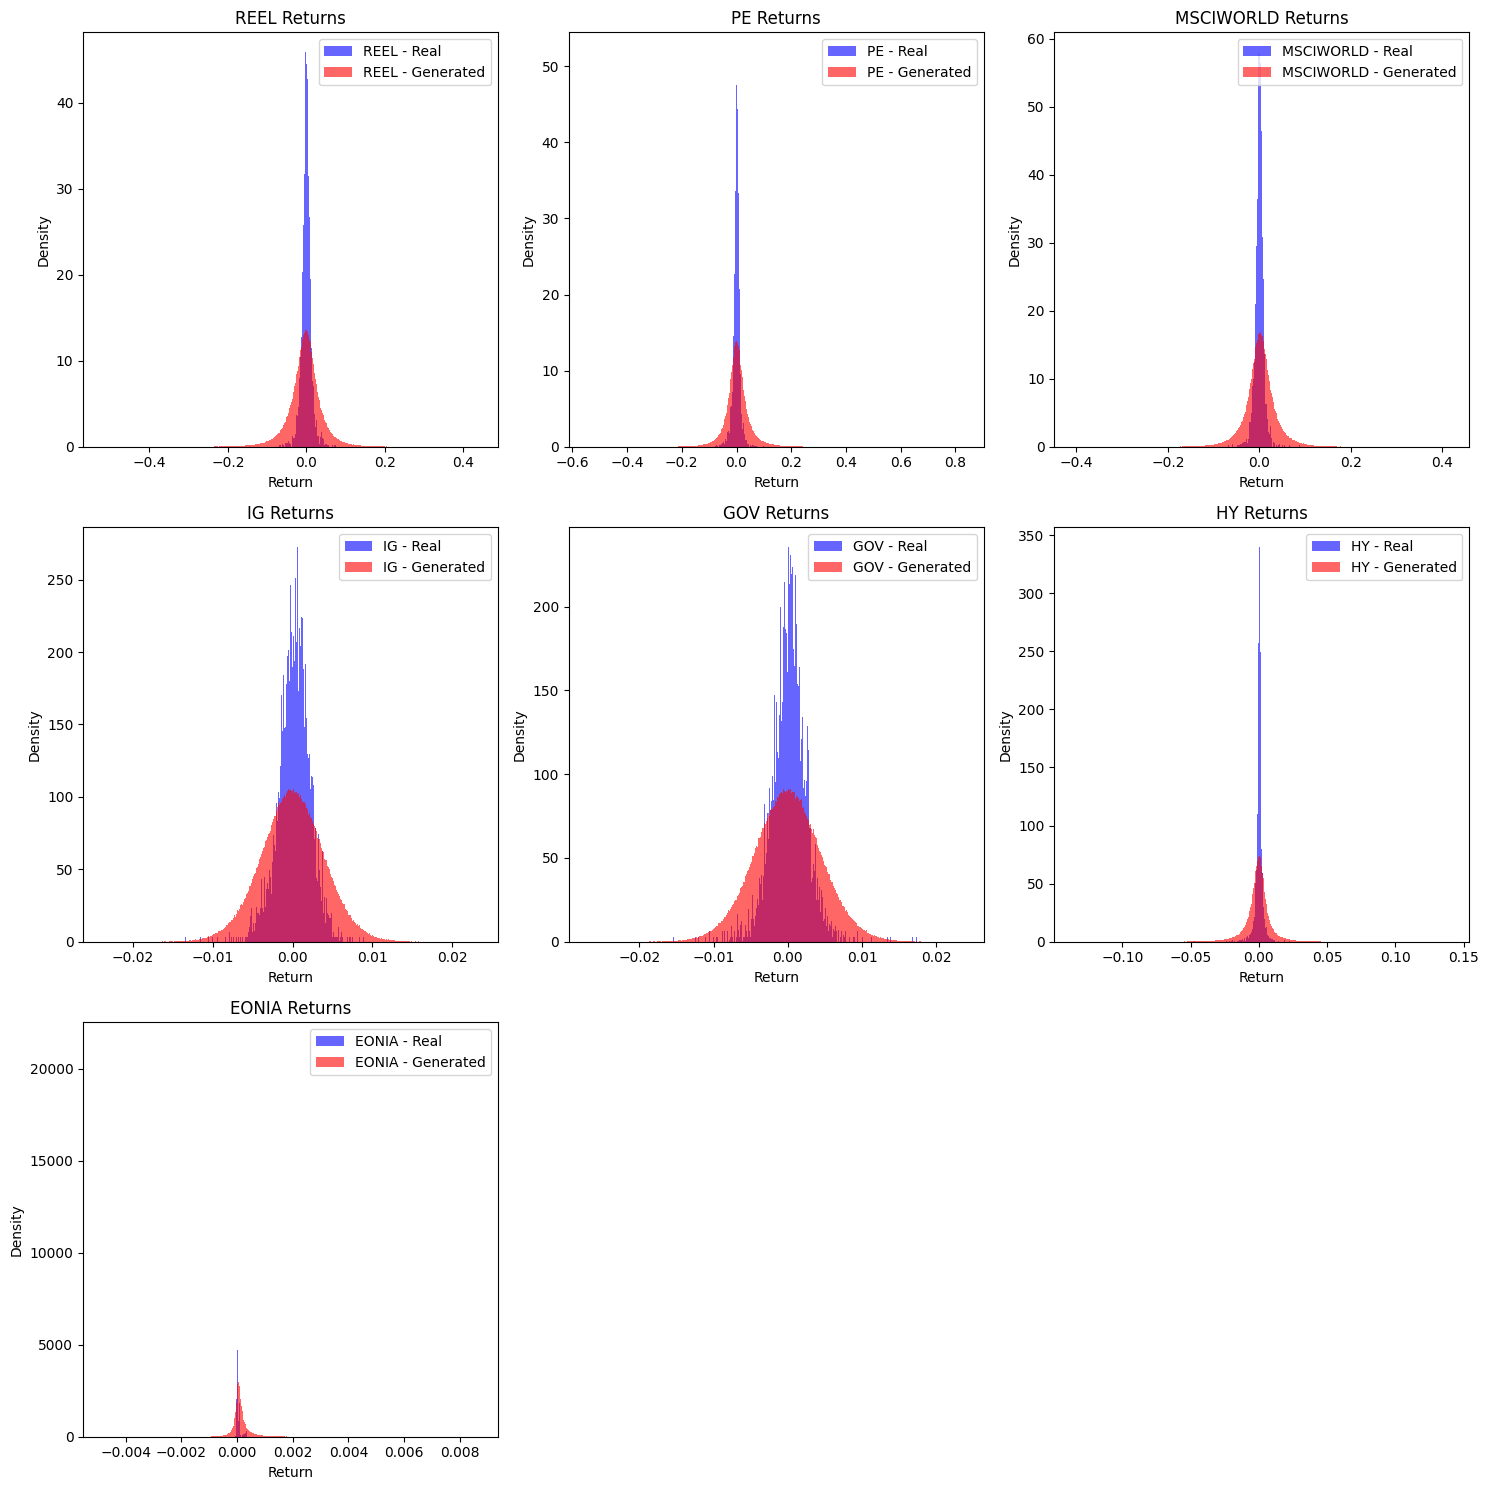


📊 Return Statistics Summary:
                Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
          REEL - Real  0.000193 0.012916 -0.270455  4.969021  -0.051644
     REEL - Generated -0.002944 0.044095 -0.342006  5.256378  -0.164569
            PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
       PE - Generated  0.003427 0.047498  0.641302  7.409082  -0.152825
     MSCIWORLD - Real  0.000283 0.009887 -0.226726  7.359869  -0.037021
MSCIWORLD - Generated  0.002245 0.035788  0.034074  5.009089  -0.120227
            IG - Real  0.000182 0.002083 -0.458256  2.226597  -0.006788
       IG - Generated -0.000011 0.003978 -0.030168  0.332066  -0.010796
           GOV - Real  0.000183 0.002449 -0.034370  4.018610  -0.008100
      GOV - Generated -0.000007 0.004568  0.007969  0.267741  -0.012212
            HY - Real  0.000279 0.003002 -1.860565 31.424899  -0.012798
       HY - Generated -0.000609 0.010597 -0.481243 11.935497  -0.044302
         EONIA - Real  0.000032 0.

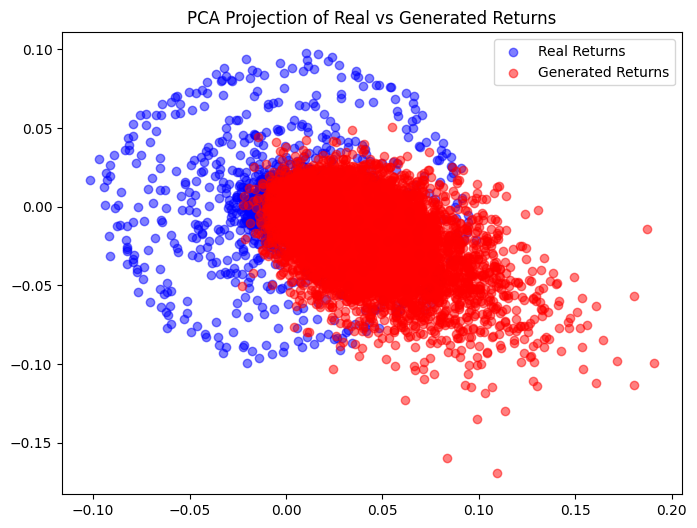

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt


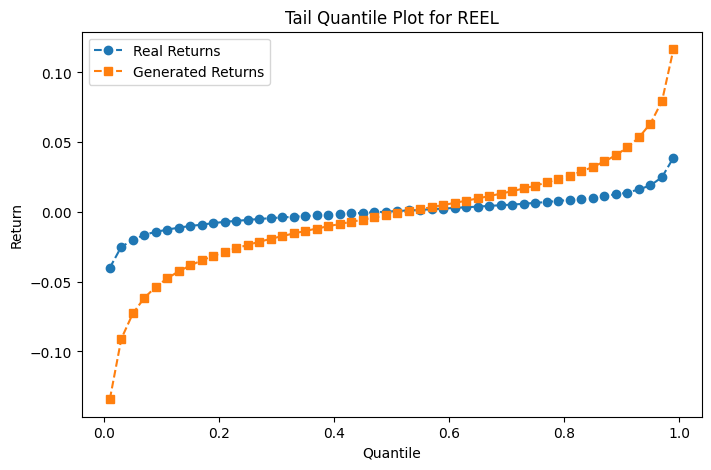


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt

📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 7.460529
Mean Distance: 0.002426
Median Distance: 0.000307
Standard Deviation: 0.039380


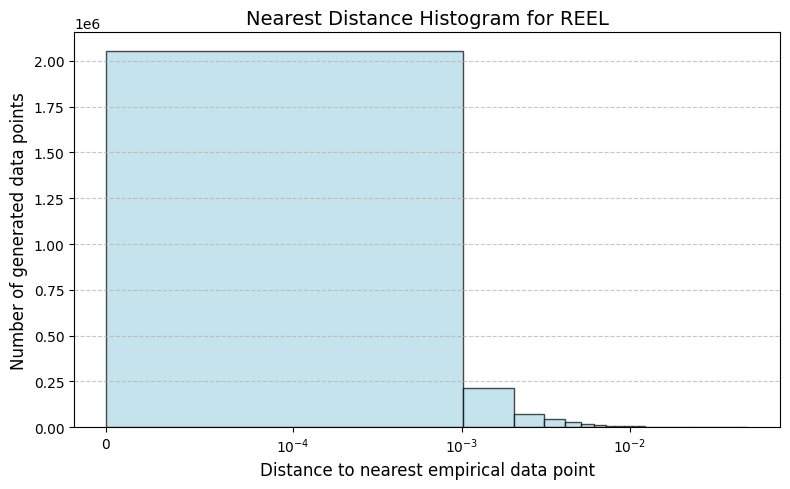


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
📊 Wasserstein Distance for REEL: 0.021773


═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Variance of Real Data: 0.000162
Variance of Generated Data: 0.000901
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.569780
✅ Generated samples are reasonably diverse


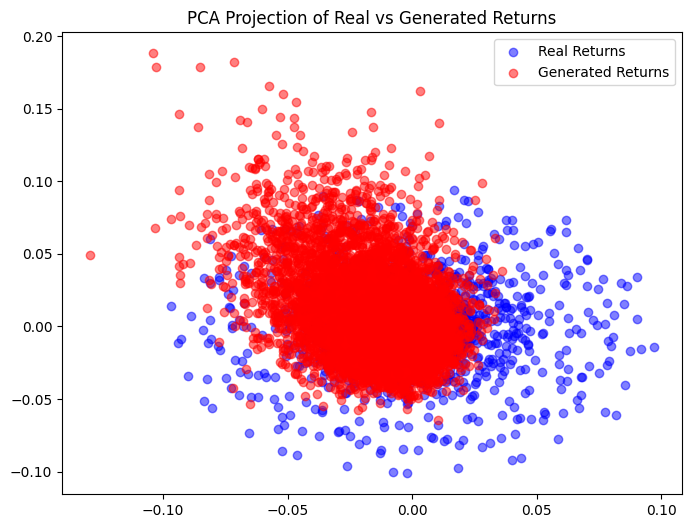

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt


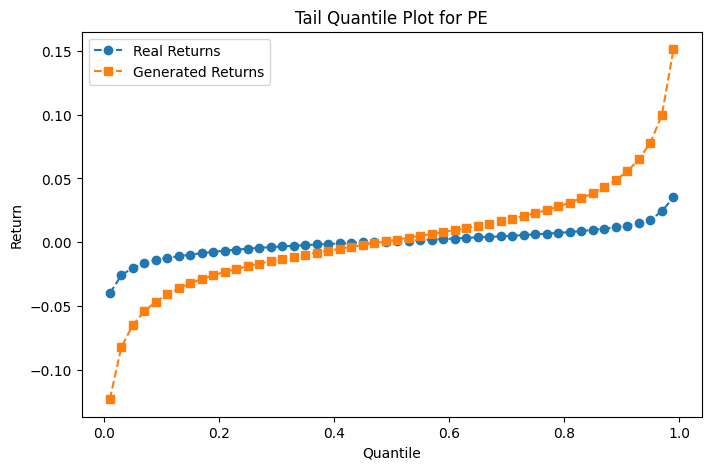


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt

📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 10.309088
Mean Distance: 0.002569
Median Distance: 0.000297
Standard Deviation: 0.040841


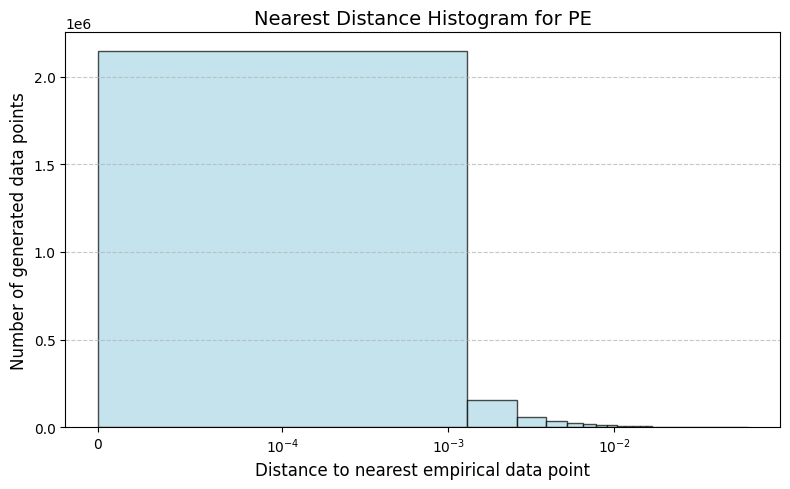


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
📊 Wasserstein Distance for PE: 0.023196


════════════════════════════════
║  ANALYZING ASSET: MSCIWORLD  ║
════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
Variance of Real Data: 0.000098
Variance of Generated Data: 0.000531
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.211255
Mean Pairwise Distance (Generated): 0.440744
✅ Generated samples are reasonably diverse


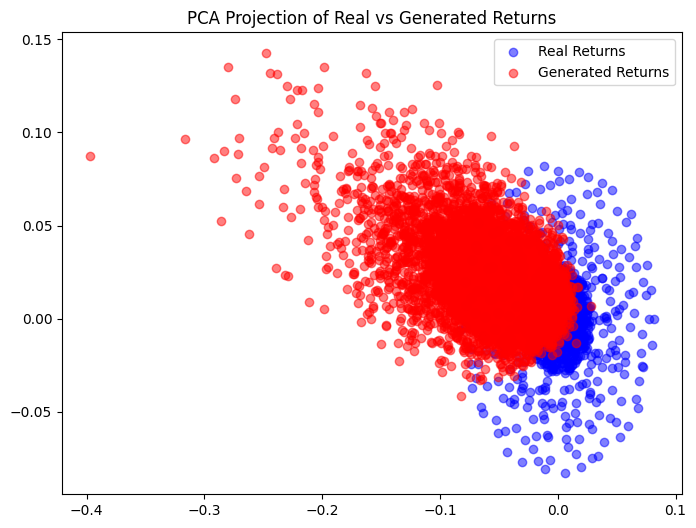

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt


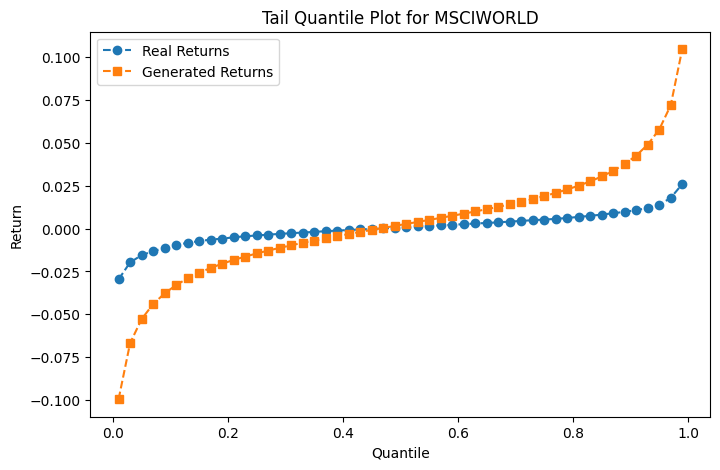


═════════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: MSCIWORLD  ║
═════════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt

📊 Distance Summary for MSCIWORLD:
Min Distance: 0.000000
Max Distance: 5.937652
Mean Distance: 0.002160
Median Distance: 0.000305
Standard Deviation: 0.023251


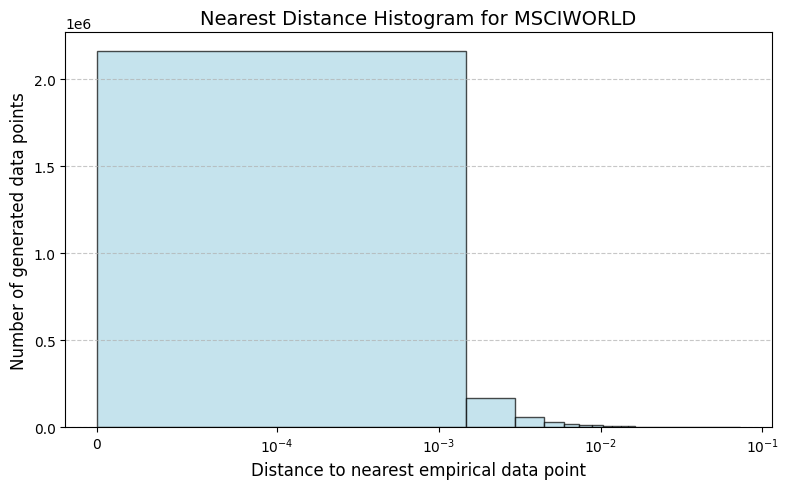


═══════════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: MSCIWORLD  ║
═══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
📊 Wasserstein Distance for MSCIWORLD: 0.018104


═════════════════════════
║  ANALYZING ASSET: IG  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
Variance of Real Data: 0.000004
Variance of Generated Data: 0.000013
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.046002
Mean Pairwise Distance (Generated): 0.079164
✅ Generated samples are reasonably diverse


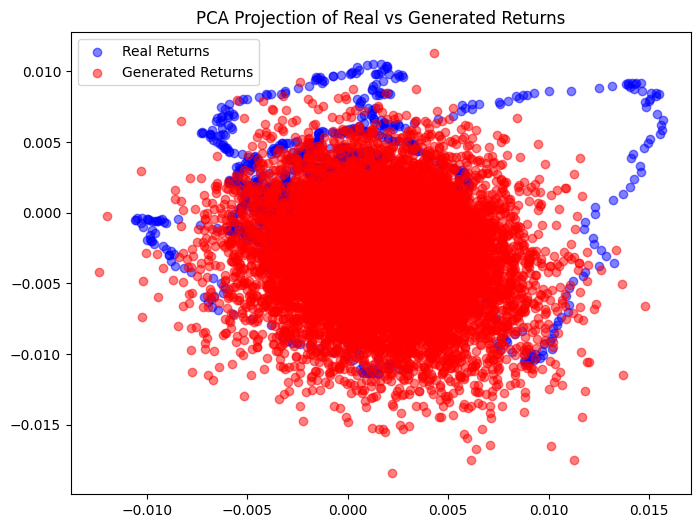

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt


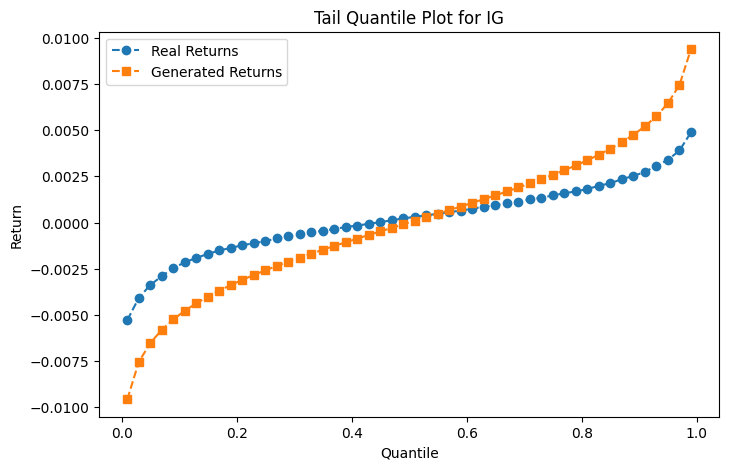


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: IG  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt

📊 Distance Summary for IG:
Min Distance: 0.000000
Max Distance: 1.326575
Mean Distance: 0.001168
Median Distance: 0.000379
Standard Deviation: 0.005641


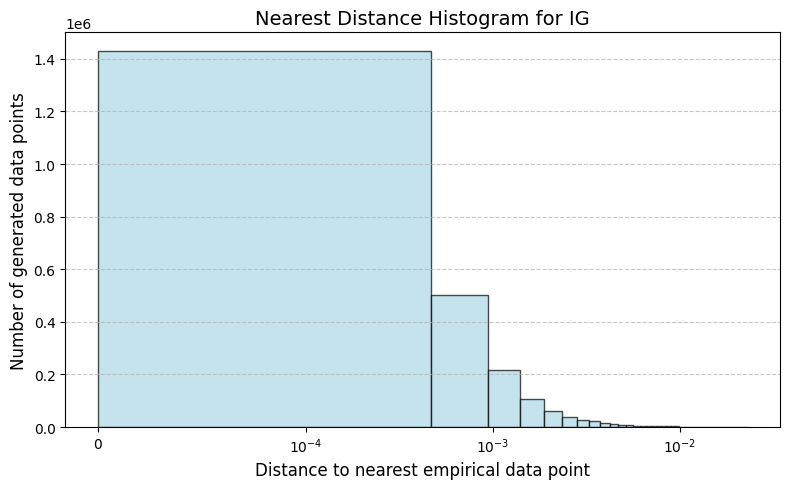


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: IG  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
📊 Wasserstein Distance for IG: 0.001581


══════════════════════════
║  ANALYZING ASSET: GOV  ║
══════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
Variance of Real Data: 0.000006
Variance of Generated Data: 0.000016
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.054322
Mean Pairwise Distance (Generated): 0.089241
✅ Generated samples are reasonably diverse


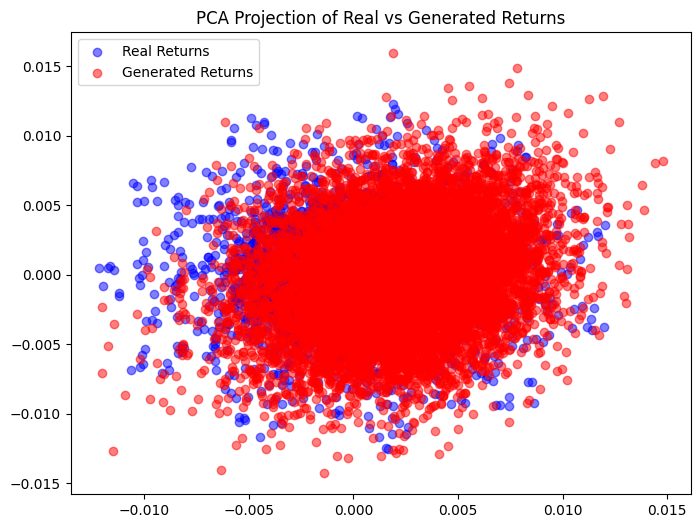

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt


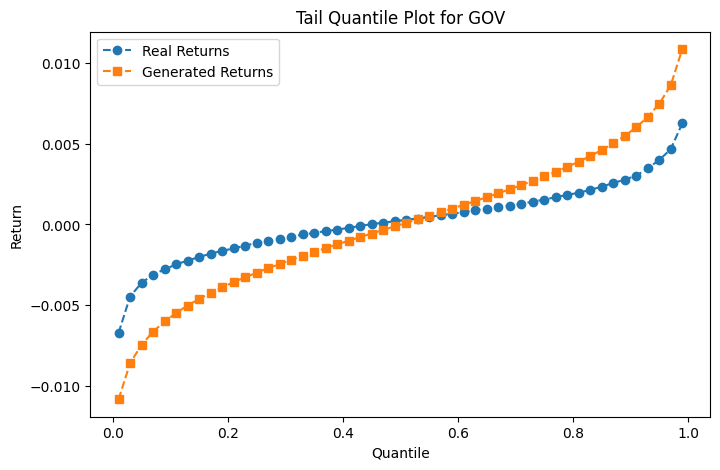


═══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: GOV  ║
═══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt

📊 Distance Summary for GOV:
Min Distance: 0.000000
Max Distance: 0.420875
Mean Distance: 0.001110
Median Distance: 0.000368
Standard Deviation: 0.004073


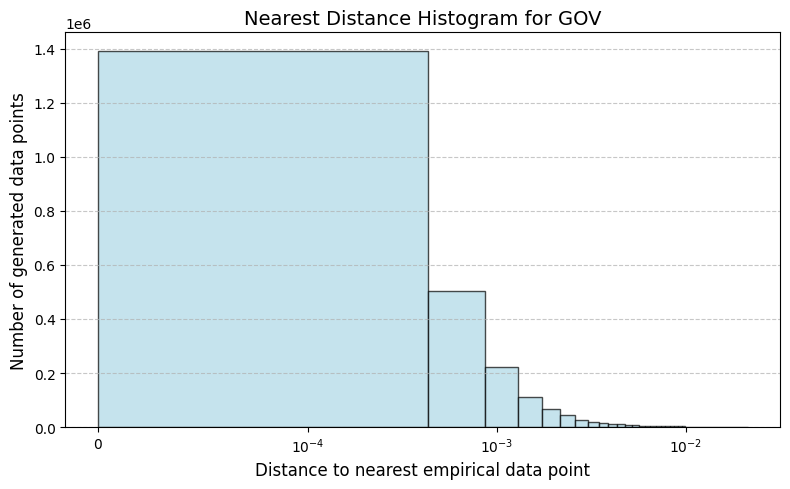


═════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: GOV  ║
═════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
📊 Wasserstein Distance for GOV: 0.001832


═════════════════════════
║  ANALYZING ASSET: HY  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
Variance of Real Data: 0.000009
Variance of Generated Data: 0.000060
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.060213
Mean Pairwise Distance (Generated): 0.133072
✅ Generated samples are reasonably diverse


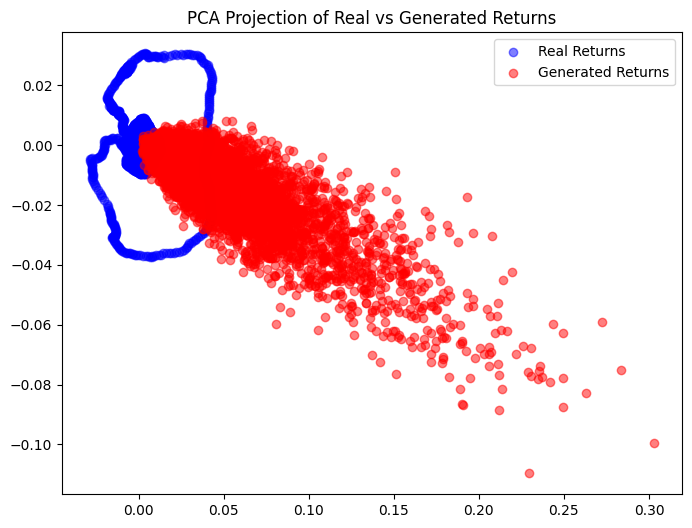

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt


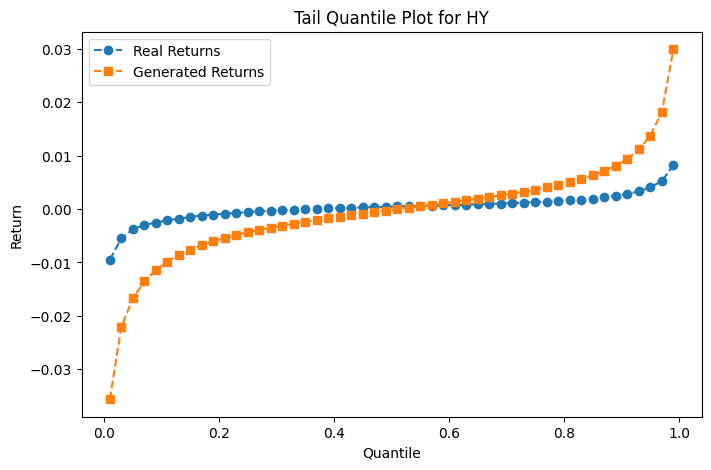


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: HY  ║
══════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt

📊 Distance Summary for HY:
Min Distance: 0.000000
Max Distance: 7.231453
Mean Distance: 0.003005
Median Distance: 0.000251
Standard Deviation: 0.041342


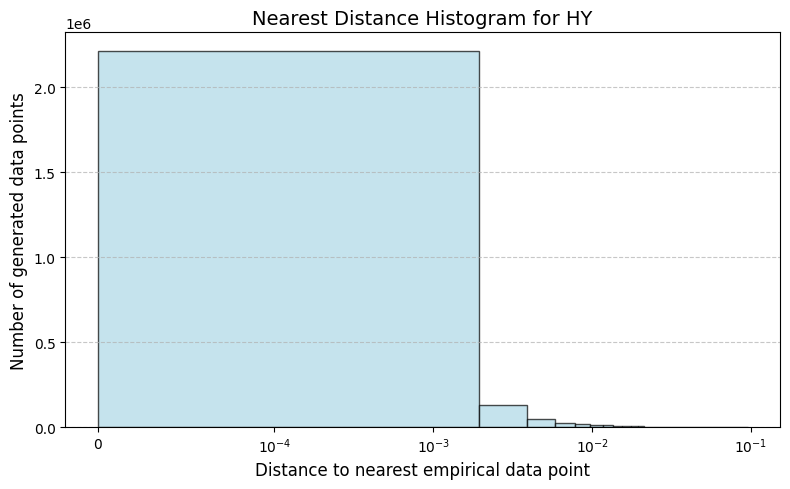


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: HY  ║
════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
📊 Wasserstein Distance for HY: 0.004907


════════════════════════════
║  ANALYZING ASSET: EONIA  ║
════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
Variance of Real Data: 0.000000
Variance of Generated Data: 0.000000
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.001171
Mean Pairwise Distance (Generated): 0.004678
✅ Generated samples are reasonably diverse


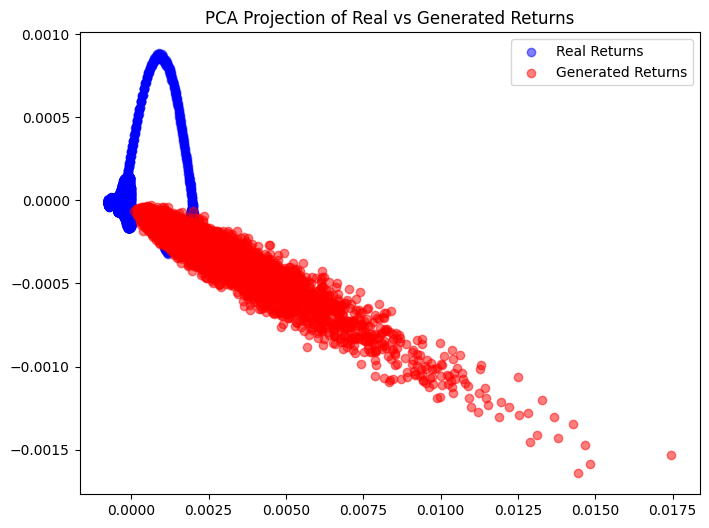


═══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: EONIA  ║
═══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
📊 Wasserstein Distance for EONIA: 0.000187



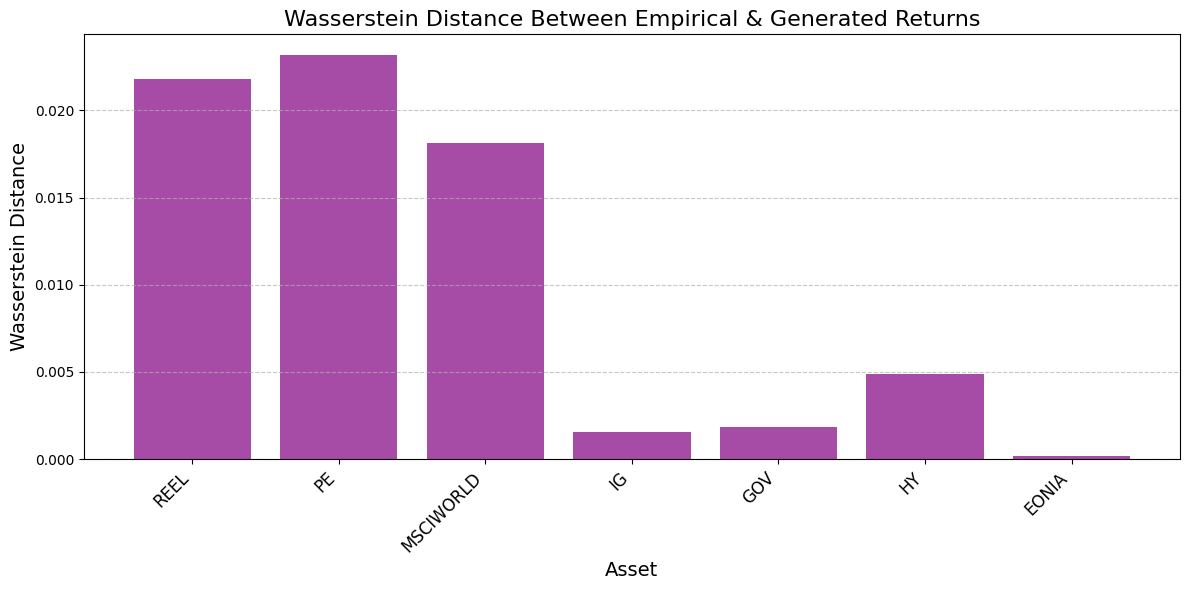

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=False, quarterly=False)

# ----------------------------------------------------------

In [ ]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [ ]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_REEL_q0.pt'